<h3>Unsupervised Learning Trading Strategy</h3>

- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns. 

<h3>All Packages</h3>
- pandas
- numpy
- matplotlib
- statsmodels
- pandas_datareader
- datetime
- yfinance
- sklearn
- PyPortfolioOpt

<h3>Download / Load SP500 stocks prices data.</h3>

In [22]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

#Not Survivorship Bias free
symbols_list = sp500['Symbol'].unique().tolist()

# end_date = '2023-09-27'

# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# df = yf.download(tickers=symbols_list,
#                start=start_date,
#                end=end_date).stack()

# df.index.names = ['date', 'ticker']
# df

# df.columns = df.columns.str.lower()
# df



Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425238   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004166   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

<h3>2. Calculate features and technical indicators for each stock. </h3>
<ul>
    <li>Garman-Klass Volatility</li>
    <li>RSI</li>
    <li>Bollinger Bands</li>
    <li>ATR</li>
    <li>MACD</li>
    <li>Dollar Volume</li>
</ul>

# Garman-Klass Volatility Calculation

The Garman-Klass Volatility formula is given by:

$$
\sigma_{GK}^2 = \frac{1}{2} \ln^2 \left(\frac{High}{Low}\right) - \left(2 \ln(2) - 1\right) \ln^2 \left(\frac{Close}{Open}\right)
$$

This formula takes into account the high, low, close, and open prices of a stock.


In [32]:
# df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
# df.xs('AAPL', level=1)['rsi'].plot()

# pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)
# df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
# df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
# df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
# df

#Calculate ATR Normalized for Machine Learning Model and Cluster the data
# def compute_atr(stock_data):
#     atr = pandas_ta.atr(high=stock_data['high'],
#                         low=stock_data['low'],
#                         close=stock_data['close'],
#                         length=14)
#     return atr.sub(atr.mean()).div(atr.std())
# df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
# df

#Calculate MACD Normalized 
# def compute_macd(close):
#     macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
#     return macd.sub(macd.mean()).div(macd.std())
# df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
# df

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425238   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004166   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146750  4.485761   
           YUM       1500600.0         -0.000051  36.057162  4.811707   
           ZBH       3610500.0          0.000022  31.893252  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623474  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782205  
           AAL          NaN       NaN       NaN       NaN     279.420098  
           AAPL         NaN       NaN       NaN       NaN    7234.160810  
           ABBV         NaN       NaN       NaN       NaN     462.394299  
           ABT          NaN       NaN       NaN       NaN     409.198630  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159189     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363696     183.389836  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.212559  5.271371  0.651515 -1.188278     256.251875  

[985955 rows x 14 columns]

<h3>3.Aggregate to monthly level and filter top 150 most liquid stocks for each month.</h3>
<ul>
    <li>To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.</li>
</ul>

In [112]:
#Dollar Volume aggregation
# last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
#                                                          'high','low','close']]
# last_cols
# df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

#Stack into multi index
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker') ], axis=1).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.740917   38.950893         -0.002098  73.421326   
           AAL        287.915786   39.429928         -0.000966  40.718966   
           AAPL      4023.983939   26.854128         -0.003307  55.537275   
           ABBV       334.491186   40.025845         -0.062372  49.376878   
           ABT        210.542063   38.091496         -0.011927  56.962648   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361752   78.356506         -0.000097  33.116259   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670368  107.862030          0.000131  55.245482   
           GEHC       212.197215   66.105721          0.000185  40.922336   
           KVUE       670.804320   20.006195         -0.000159  35.706316   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689080 -1.033887  0.567158  
           AAL     3.672028  3.749832  3.827635  0.190822 -0.418772  
           AAPL    3.281679  3.324991  3.368302 -0.967900 -0.142790  
           ABBV    3.717771  3.766009  3.814247 -0.526809  0.145677  
           ABT     3.650901  3.672752  3.694603 -1.064842  0.335558  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534535  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.652147  4.692320  4.732493 -0.436215  0.366876  
           GEHC    4.155071  4.212607  4.270142 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435621  

[46553 rows x 9 columns]

<ul>
    <li>Calculate 5-year rolling average of dollar volume for each stocks before filtering.</li>
</ul>

In [113]:
#Rolling Average Dollar Volume for each stock
data['dollar_volume']=(data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())


#Calculate Dollar Volume Rank Cross Sectionally for each month
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))


#Get top 150 most liquid stocks for each month
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134335         -0.000176  62.203571  3.604673   
           AAPL     26.212475         -0.002468  49.891088  3.294237   
           ABBV     39.878788         -0.049190  27.477832  3.744517   
           ABT      34.112473         -0.008074  38.008772  3.549492   
           ACN     103.117401         -0.005023  53.823659  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440183  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131596  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.798670  3.852823 -0.893132 -0.760593  
           ABT     3.599959  3.650426 -1.035224 -0.650888  
           ACN     4.644646  4.656283 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

<h3>4.Calculate Monthly Returns for different time horizons as features. </h3>
<ul>
    <li>To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.</li>
</ul>

In [114]:
# g = df.xs('AAPL', level=1)
# g

def calculate_returns(df):
    #Clipping off the outlier stocks setting the threshhold 99.5 percentile
    outlier_cutoff = 0.005
    #months 
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags: 
        df[f'return_{lag}m'] = (df['adj close']
                             .pct_change(lag)
                             .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                               upper=x.quantile(1-outlier_cutoff)))
                             .add(1)
                             .pow(1/lag)
                             .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534161         -0.000363  41.051754  3.849110   
           AAPL     39.713905         -0.001055  69.196761  3.594730   
           ABBV     66.876793         -0.036142  55.247845  4.187696   
           ABT      48.237469         -0.005677  53.844932  3.887385   
           ACN     128.834671         -0.004274  69.364849  4.798335   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440183  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039275   0.096808   
           ABBV    4.234050  4.280405  0.375557  0.473814   0.022728   
           ABT     3.910952  3.934519 -1.040044  0.276133   0.021276   
           ACN     4.838013  4.877691 -0.986514  0.352343   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10342 rows x 14 columns]

<h3>5.Download Fama-French Factors and Calculate Rolling Factor Betas</h3>
<ul>
    <li>We will introduce the Fama - French data to estimate the exposure of assets to common risk factors using linear regression.</li>
    <li>The five Fama - French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exporsures as financial features in models. </li>
    <li>We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.</li>
</ul>

In [115]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10342 rows x 6 columns]

In [107]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2021-10-31,0.0665,-0.0270,-0.0049,0.0166,-0.0145,0.058657
2021-11-30,-0.0155,-0.0177,-0.0045,0.0720,0.0173,0.105082
2021-12-31,0.0310,-0.0080,0.0326,0.0491,0.0440,0.074229
2022-01-31,-0.0625,-0.0406,0.1275,0.0085,0.0773,-0.015712
2022-02-28,-0.0229,0.0292,0.0309,-0.0209,0.0312,-0.054066


In [108]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2021-10-31,0.0665,-0.0270,-0.0049,0.0166,-0.0145,0.172821
2021-11-30,-0.0155,-0.0177,-0.0045,0.0720,0.0173,-0.001282
2021-12-31,0.0310,-0.0080,0.0326,0.0491,0.0440,0.017333
2022-01-31,-0.0625,-0.0406,0.1275,0.0085,0.0773,-0.075345
2022-02-28,-0.0229,0.0292,0.0309,-0.0209,0.0312,-0.037212


<ul>
    <li>Filter out stocks with less than 10 months of data</li>
</ul>

In [119]:
#Why because we are going to use Rolling Window of regression of 2 years
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10318 rows x 6 columns]

<ul>
    <li>Calculate Rolling Factor Betas</li>
</ul>

In [121]:
betas= (factor_data.groupby(level=1,
                    group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'],
                           exog=sm.add_constant(x.drop('return_1m', axis=1)),
                           window=min(24, x.shape[0]),
                           min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456835 -0.444629 -0.314191 -0.077989  0.802008
           VZ      0.332723 -0.166036  0.265927  0.311104  0.108625
           WFC     1.120622  0.297483  2.062607 -0.441340 -1.519516
           WMT     0.700773 -0.313571 -0.413681 -0.141574  0.508838
           XOM     0.983098 -1.094428  1.756405 -0.640018 -0.368885

[10318 rows x 5 columns]

In [124]:
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.505307 -0.410033 -0.482589  0.058119  0.944935
           VZ      0.302564 -0.212632  0.342986  0.318856  0.002803
           WFC     1.136804  0.311860  2.009513 -0.406323 -1.469895
           WMT     0.740244 -0.259781 -0.522484 -0.125197  0.642485
           XOM     1.005608 -1.051740  1.707635 -0.674968 -0.284573

[10318 rows x 5 columns]

In [133]:
# factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# data = (data.join(betas.groupby('ticker').shift()))

# data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# data = data.drop('adj close', axis=1)

# data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10096 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10096 non-null  float64
 1   rsi               10096 non-null  float64
 2   bb_low            10096 non-null  float64
 3   bb_mid            10096 non-null  float64
 4   bb_high           10096 non-null  float64
 5   atr               10096 non-null  float64
 6   macd              10096 non-null  float64
 7   return_1m         10096 non-null  float64
 8   return_2m         10096 non-null  float64
 9   return_3m         10096 non-null  float64
 10  return_6m         10096 non-null  float64
 11  return_9m         10096 non-null  float64
 12  return_12m        10096 non-null  float64
 13  Mkt-RF            10096 non-null  float64
 14  SMB               10096 non-null  float64
 15  HML       

<p>Use machine learning model to choose which stocks to include in the portfolio.</p>
<p>Long portfolio. We can use Machine Learning Model to determine the magnitude of the position in each stocks. </p>
<h2>At this point we have to decide on what ML model and approach to use for predictions etc.</h2>

<h3>6. For each month fit a K-Mans Clustering Algorithm to group similar assets based on their features.</h3>
<h2>K-Means Clustering</h2>
<ul>
    <li>Split the stocks into 4 different clusters based on its features. 4 because it is the optimum number of clusters.</li>
    <li>You may want to initialize predefined centroids for each cluster based on your research.</li>
    <li>For visualization purpose of this tutorial we will initially rely on the "k-means++" initialization.</li>
    <li>Then we will pre-define our centroids for each cluster.</li>
</ul>

In [140]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051754  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196761  3.594730  3.641603  3.688475   
           ABBV           -0.036142  55.247845  4.187696  4.234050  4.280405   
           ABT            -0.005677  53.844932  3.887385  3.910952  3.934519   
           ACN            -0.004274  69.364849  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000041  54.722568  3.984976  4.002446  4.019915   
           XOM            -0.000065  59.440183  4.687091  4.727187  4.767283   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352343   0.064180   0.048454   0.037202   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276025 -0.271594   
           ABBV     0.056495   0.047273    0.044026  0.494533  0.362680   
           ABT      0.038672   0.031320    0.029294  0.828391 -0.199397   
           ACN      0.028692   0.027398    0.018728  1.199020 -0.166370   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740244 -0.259781   
           XOM      0.012838   0.008747    0.027037  1.005608 -1.051740   
           MRNA    -0.071952  -0.064976   -0.015431  1.154879  0.766422   
           UBER     0.057244   0.066838    0.043691  1.078514  1.163168   
           CRWD     0.026391   0.047942   -0.002216  0.594732 -0.940715   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.600747  0.459424  0.563336        1  
           AAPL   -0.591211  0.647542  0.458382        3  
           ABBV   -0.032807  0.242184  0.164054        2  
           ABT    -0.529385  0.251775  0.970503        2  
           ACN    -0.328321  0.268152  0.168632        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.522484 -0.125197  0.642485        2  
           XOM     1.707635 -0.674968 -0.284573        3  
           MRNA   -1.163095  0.593370  0.989911        1  
           UBER   -0.257055 -1.482917 -0.449948        1  
           CRWD   -0.678313 -2.449974 -0.814519        2  

[10096 rows x 19 columns]

In [141]:
# Atr = 5 RSI = 1
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

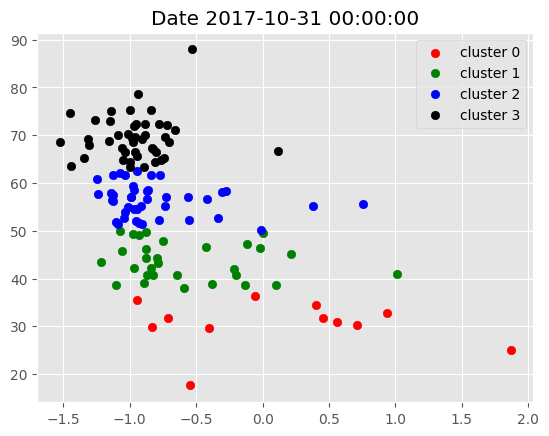

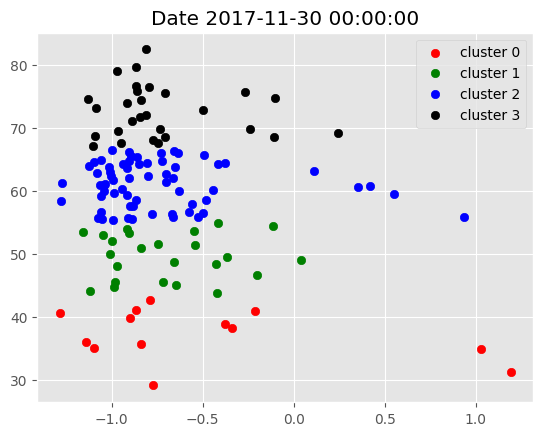

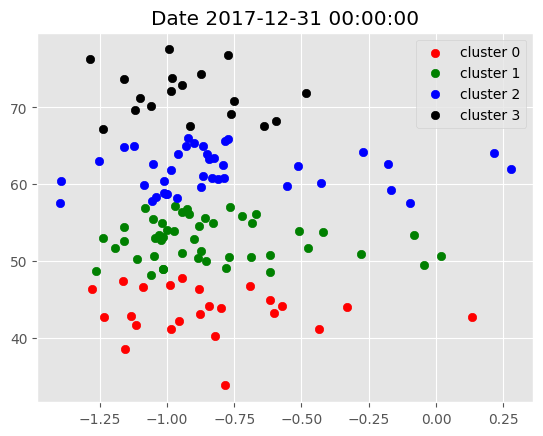

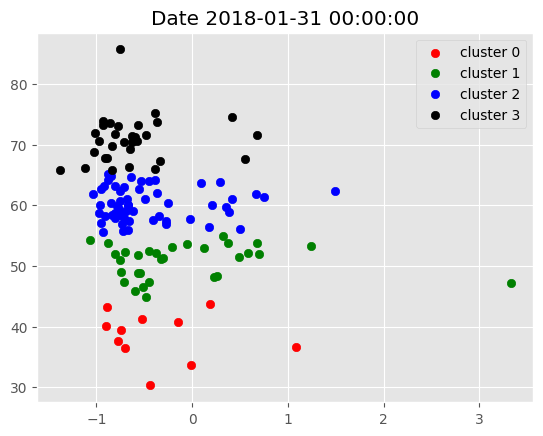

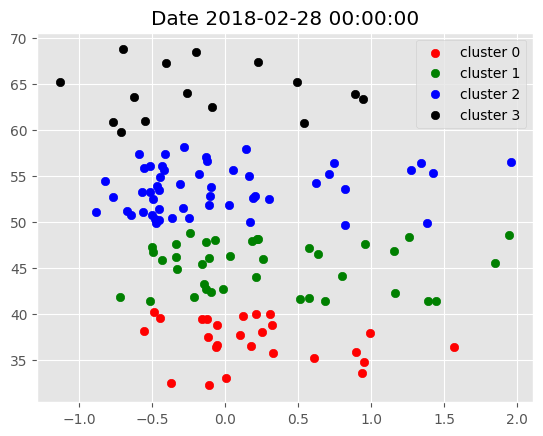

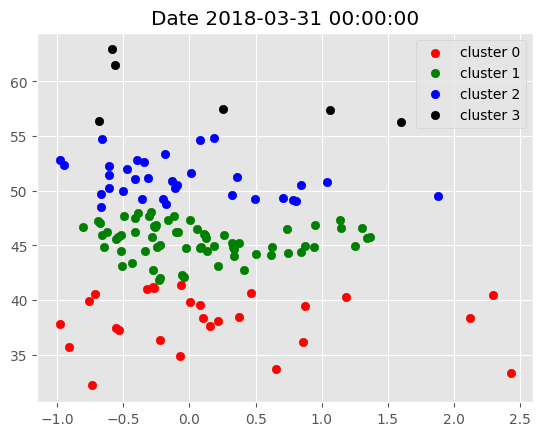

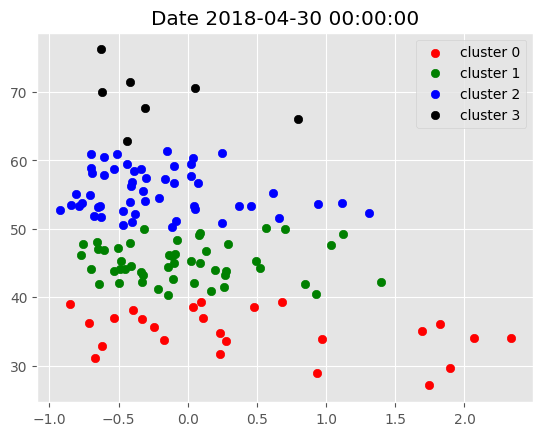

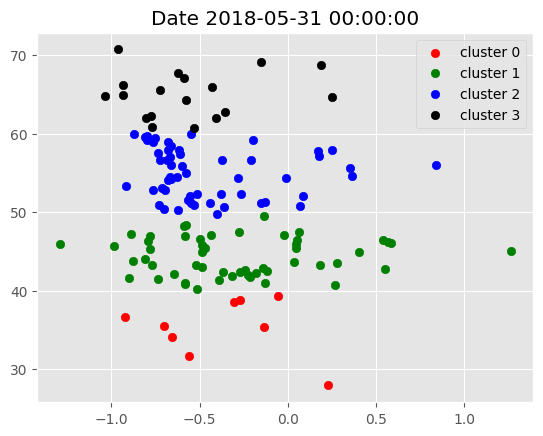

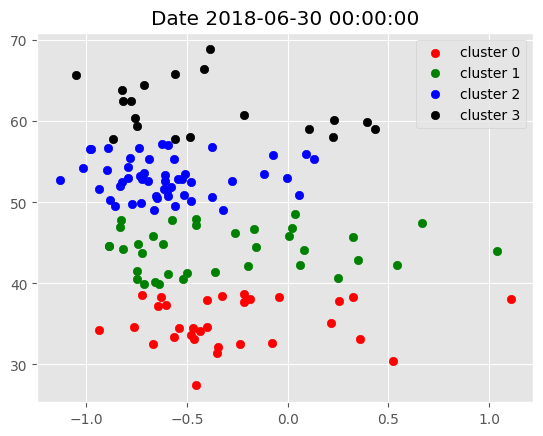

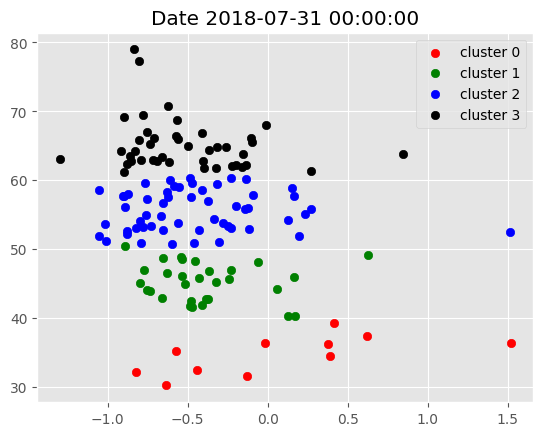

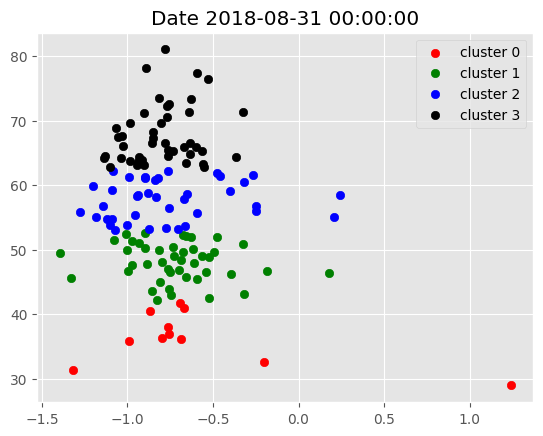

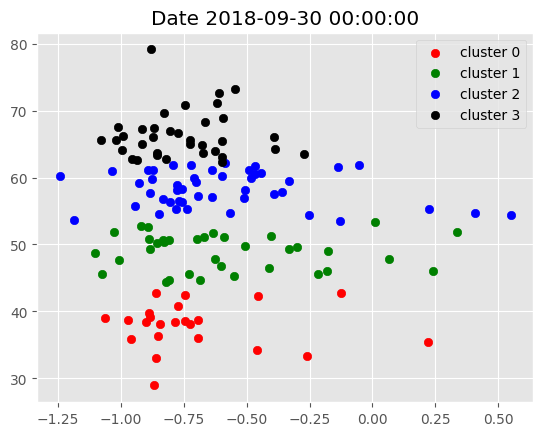

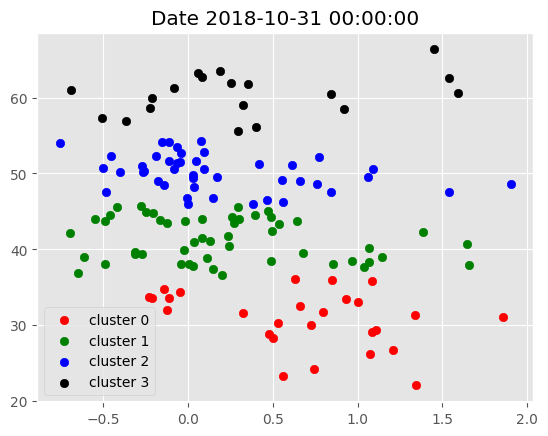

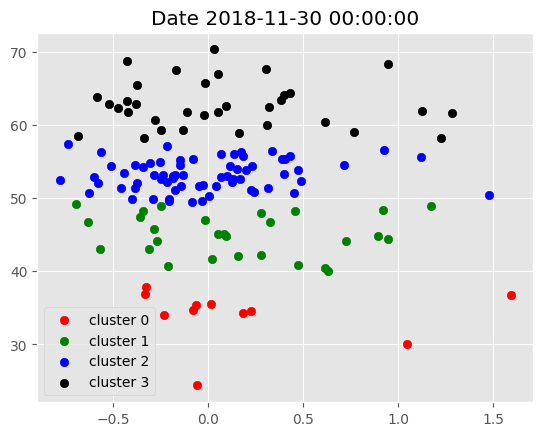

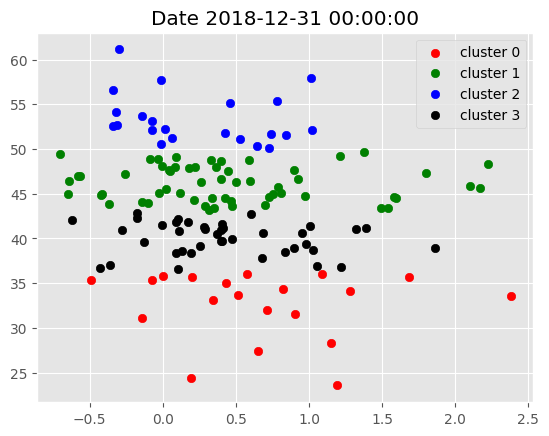

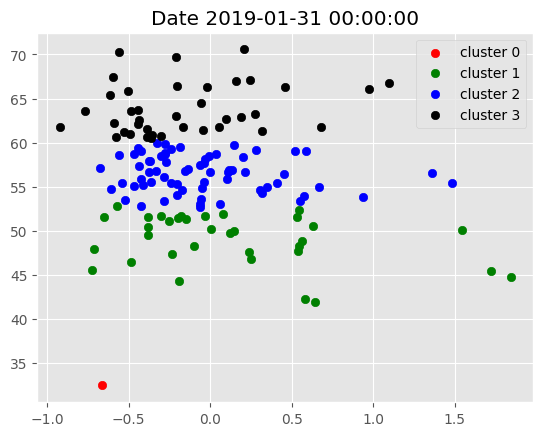

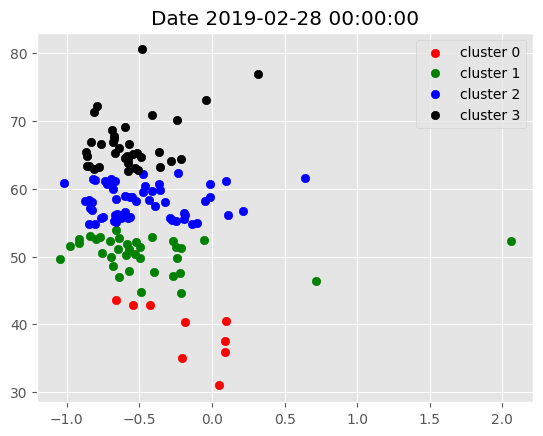

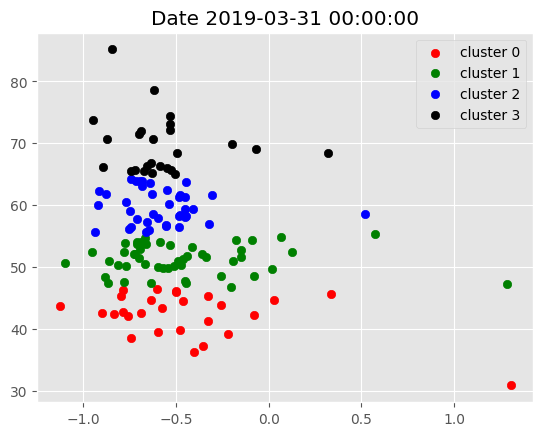

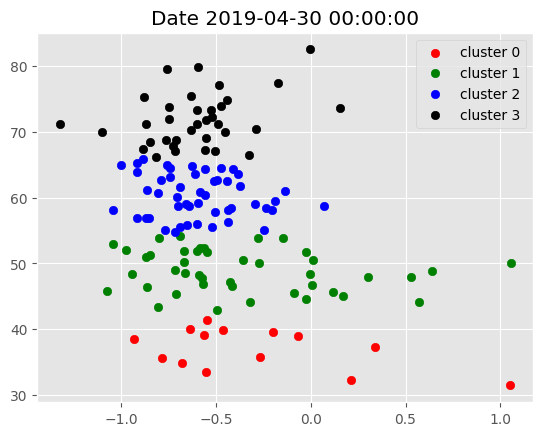

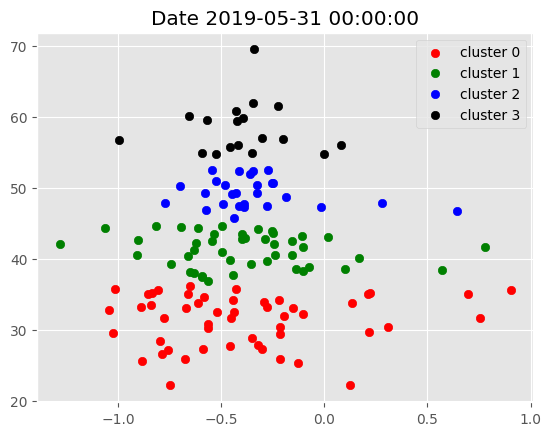

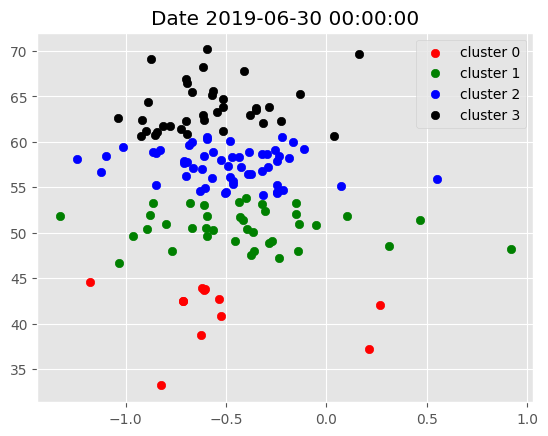

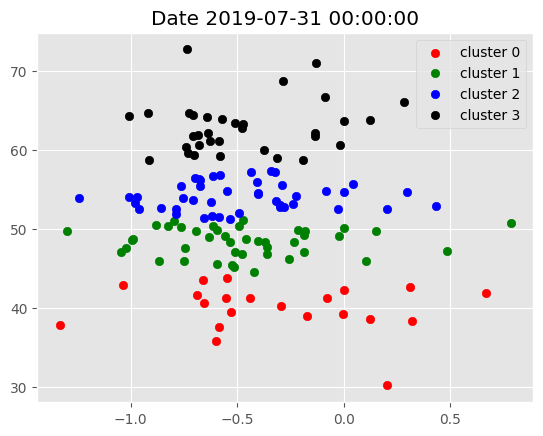

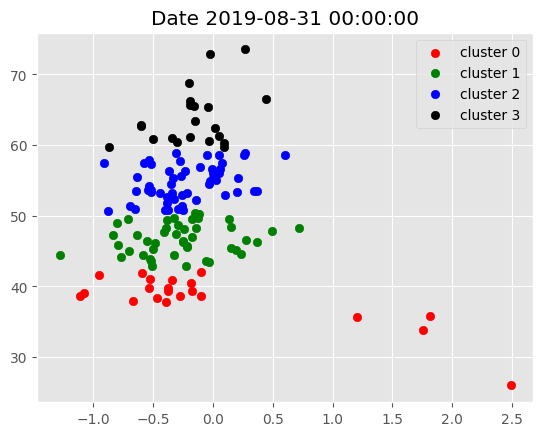

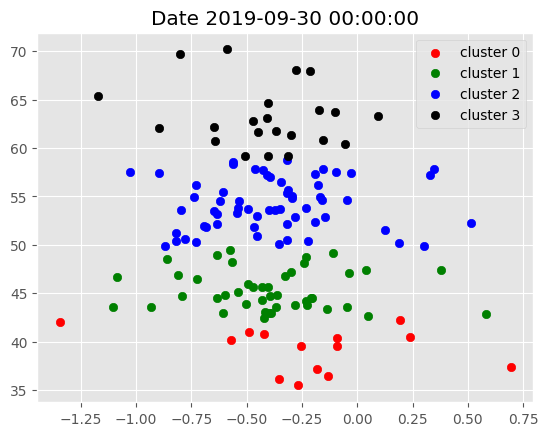

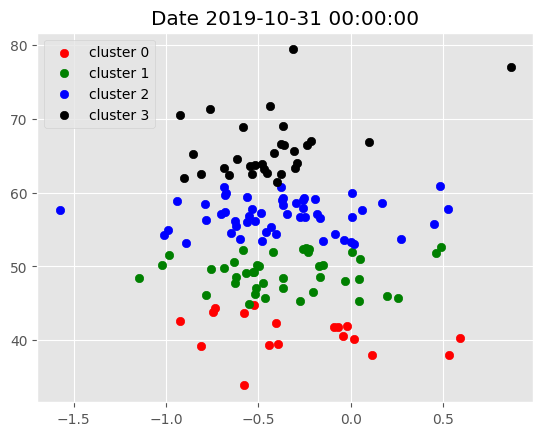

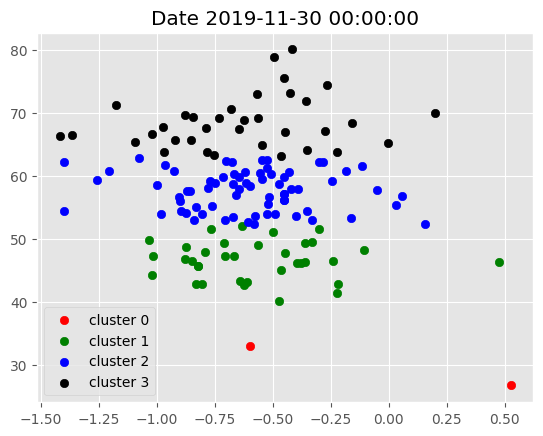

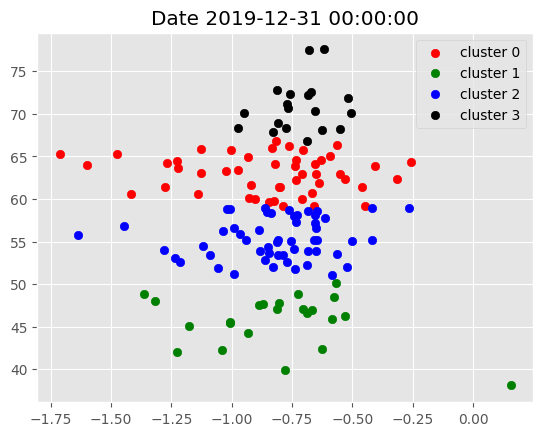

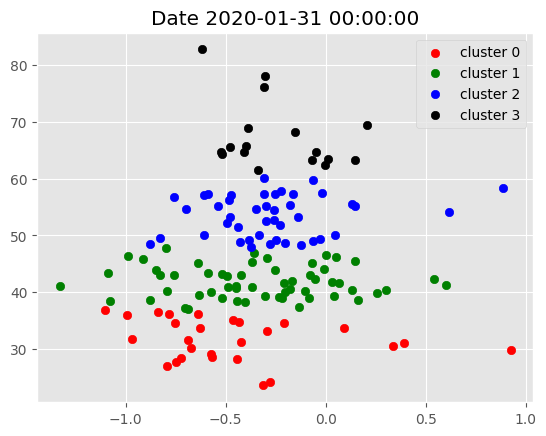

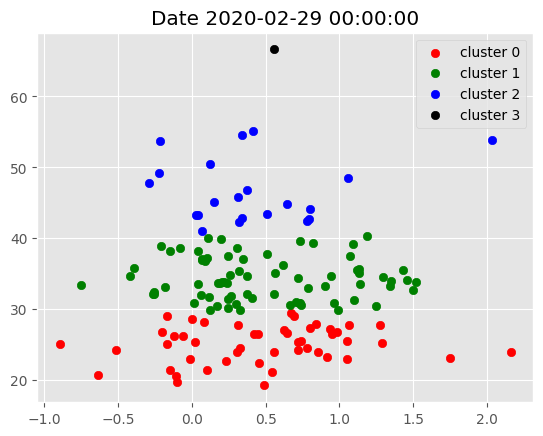

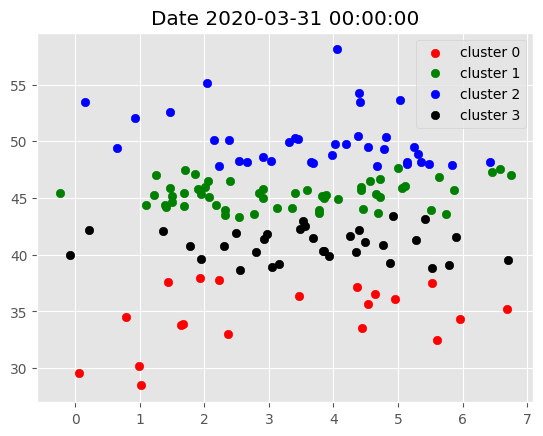

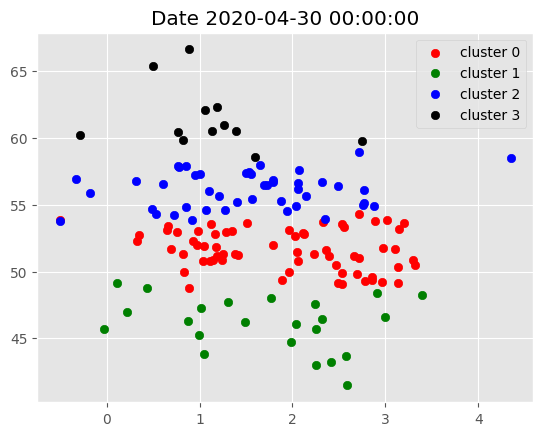

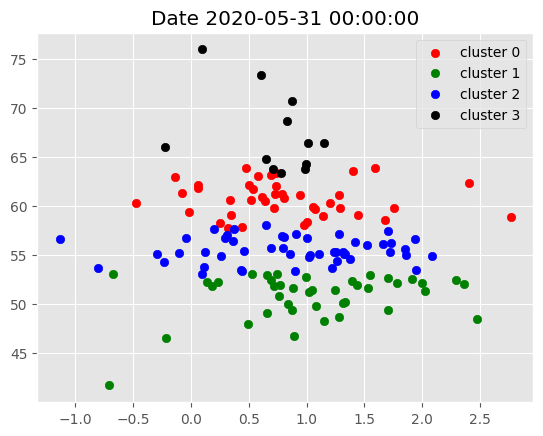

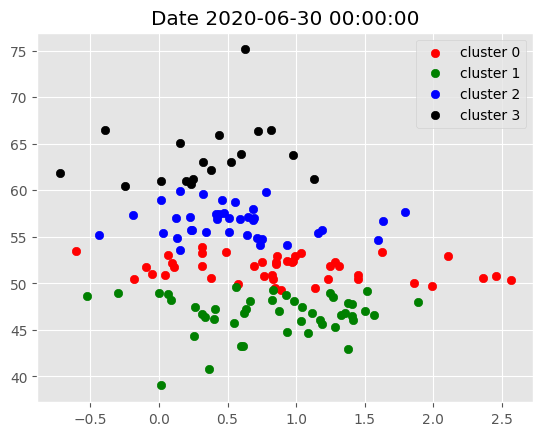

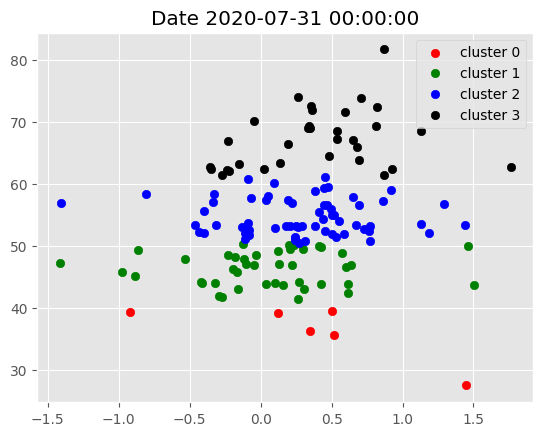

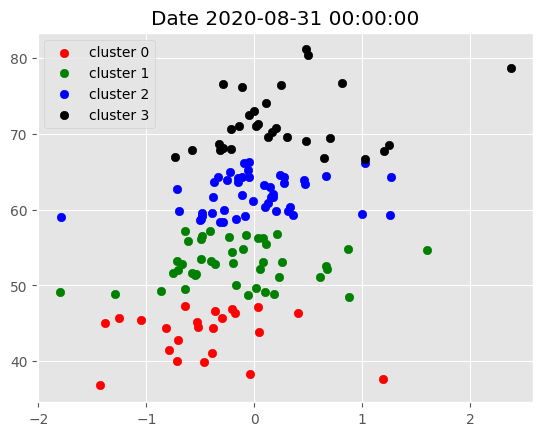

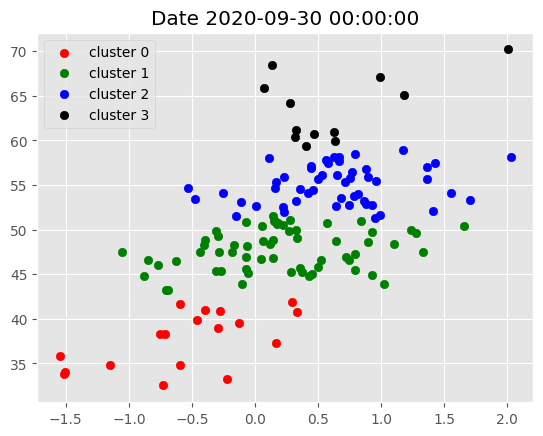

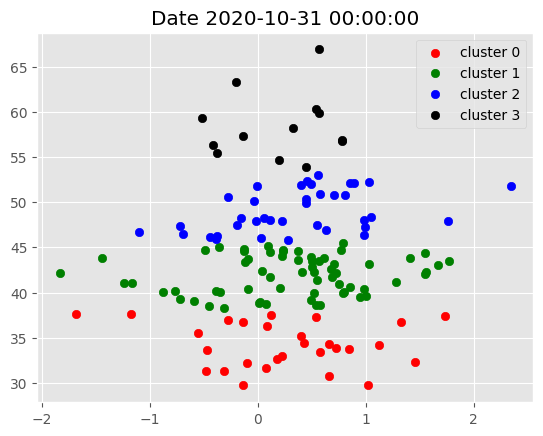

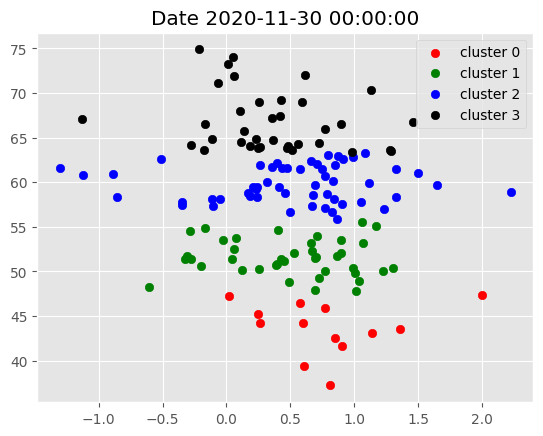

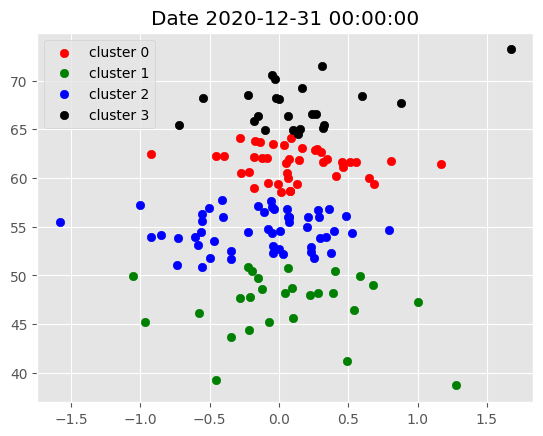

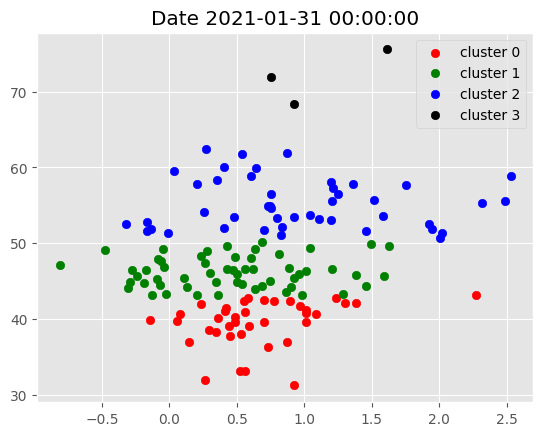

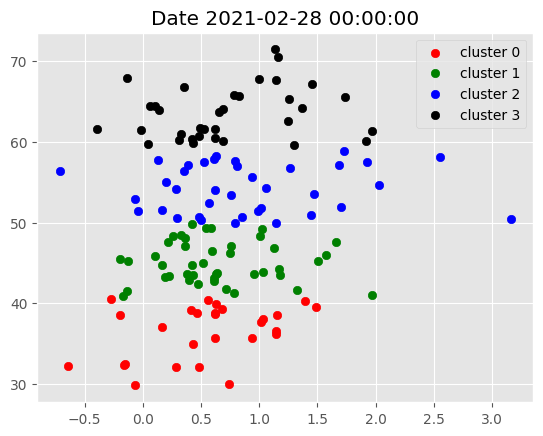

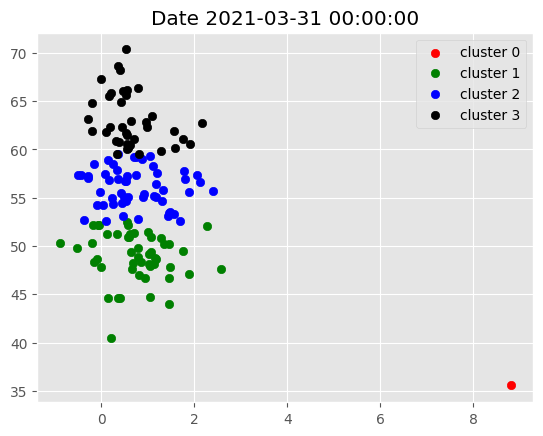

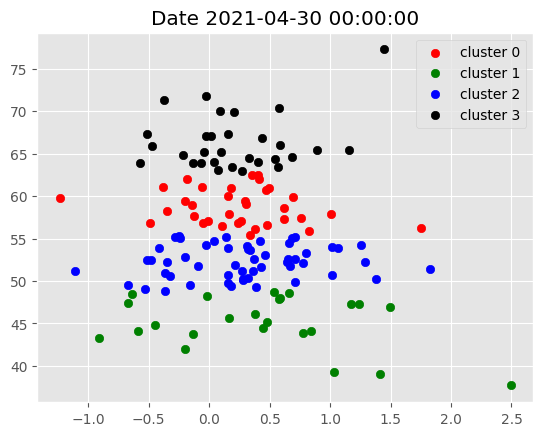

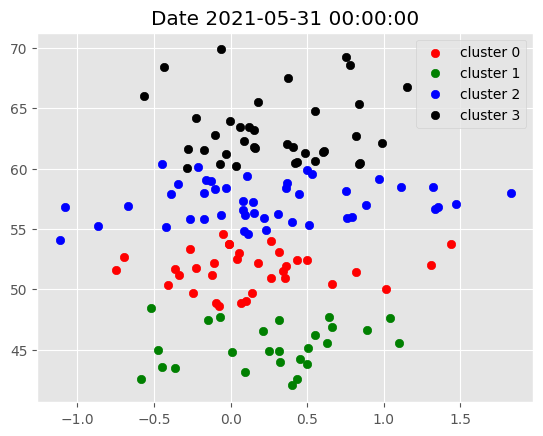

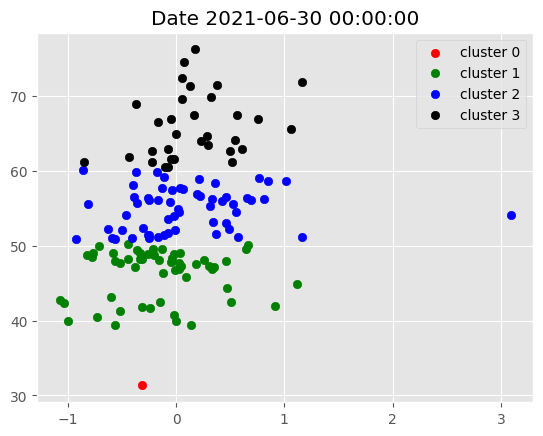

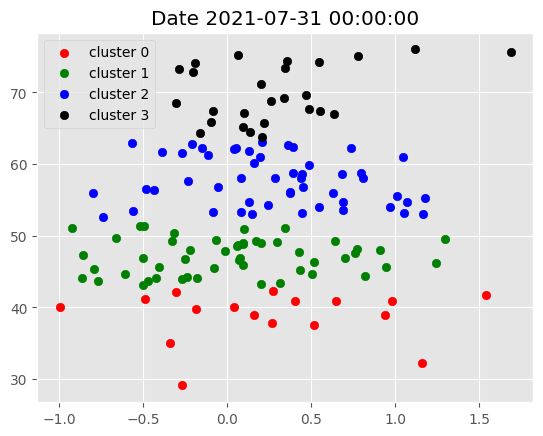

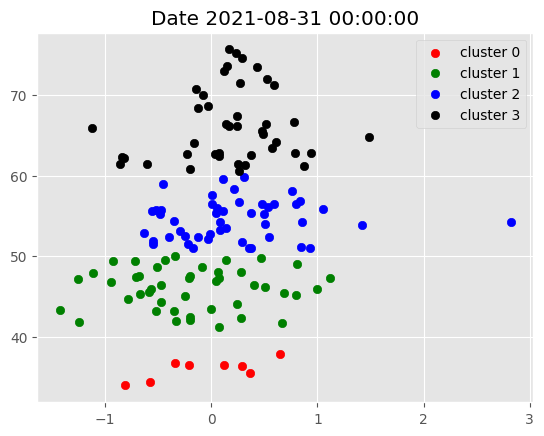

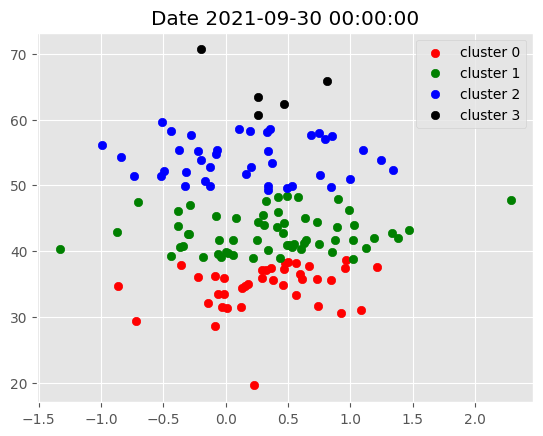

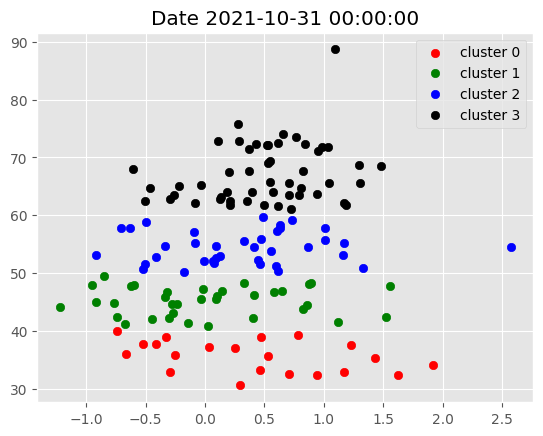

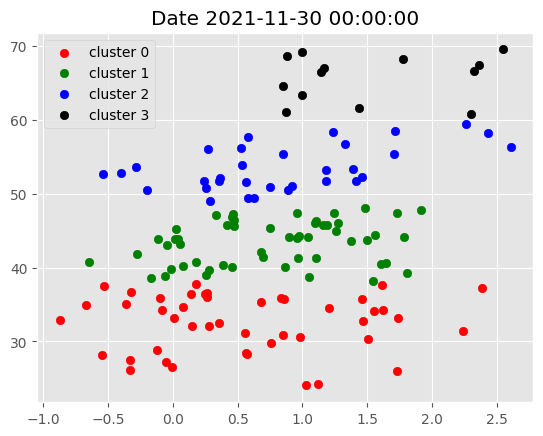

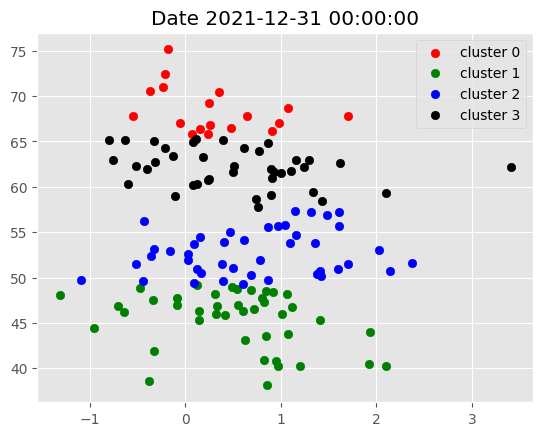

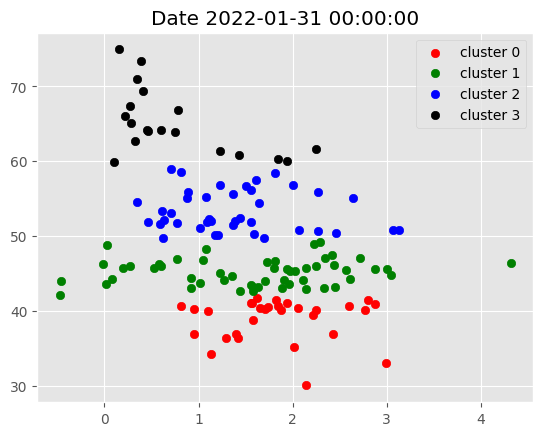

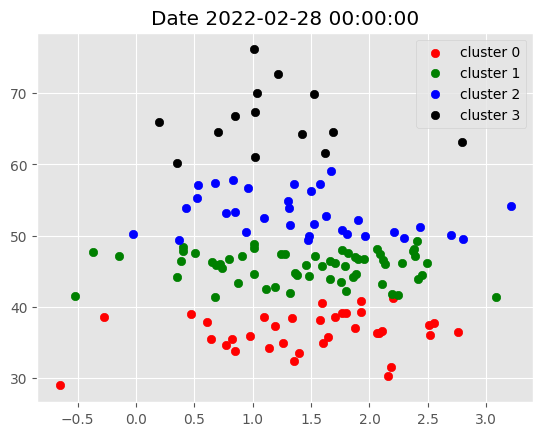

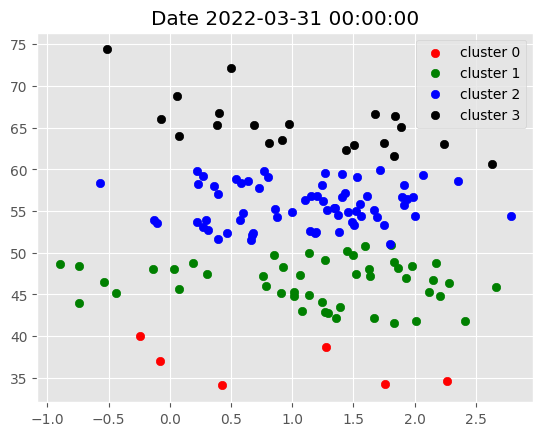

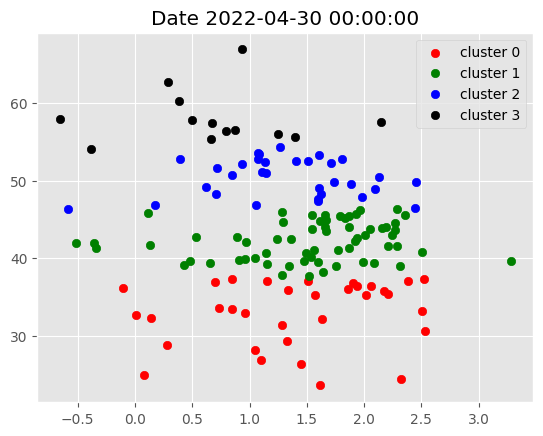

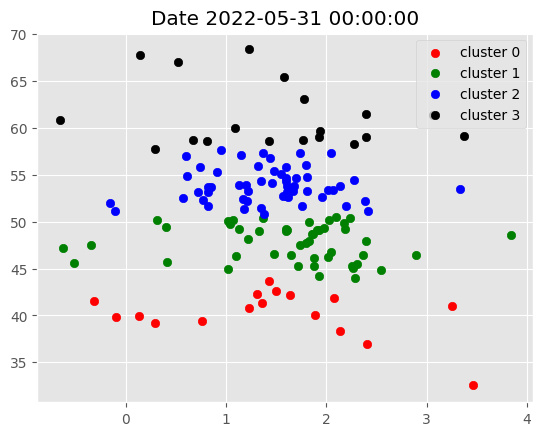

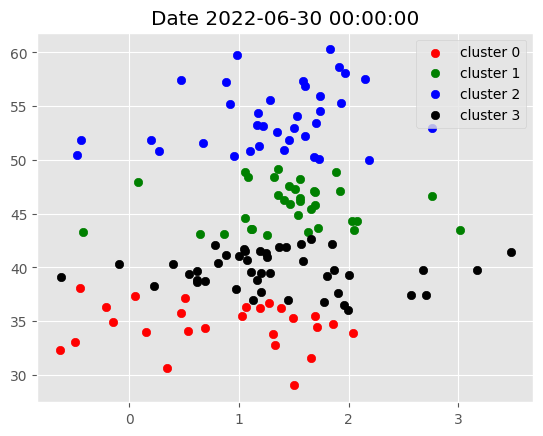

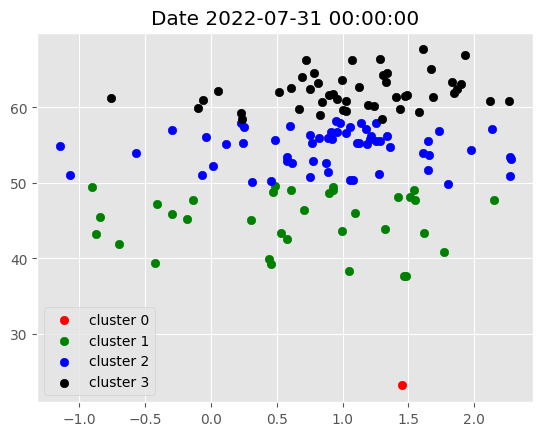

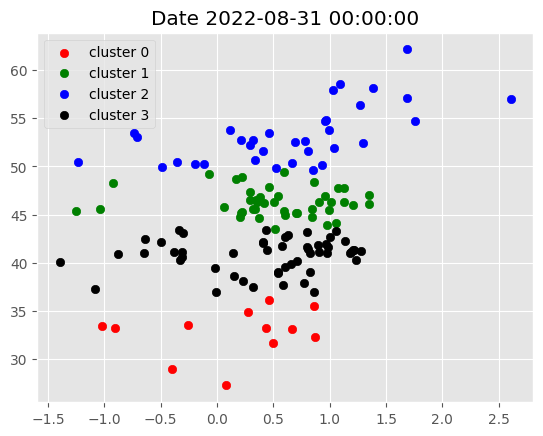

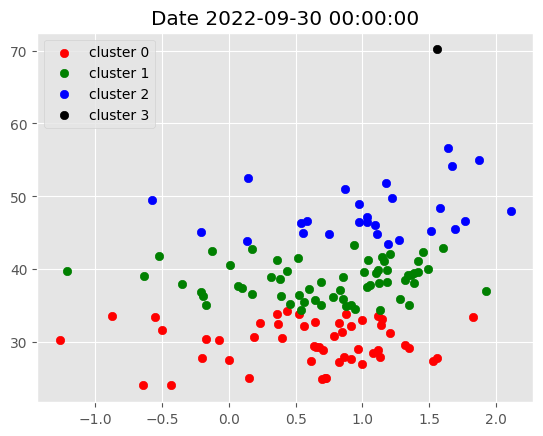

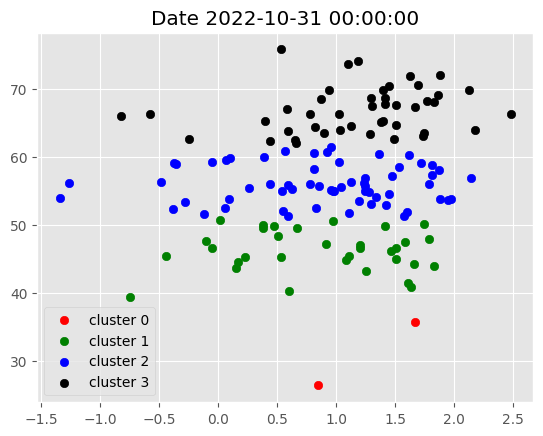

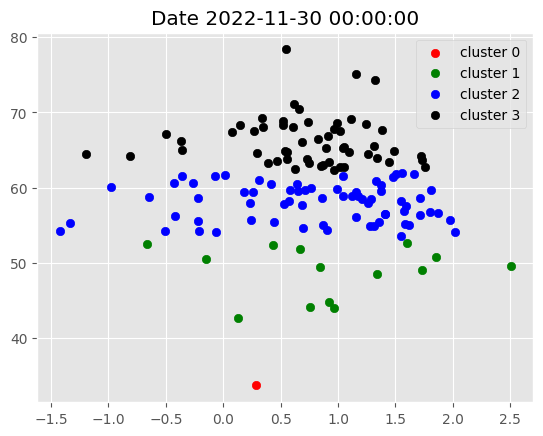

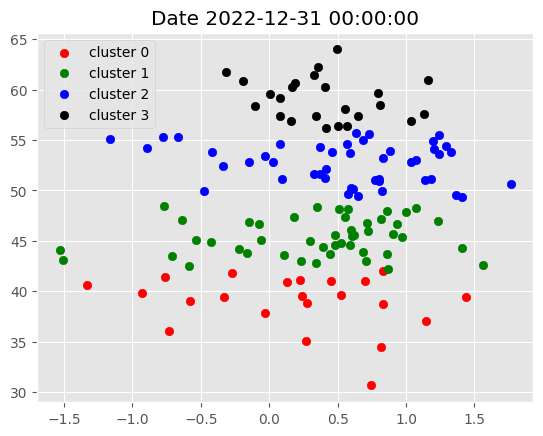

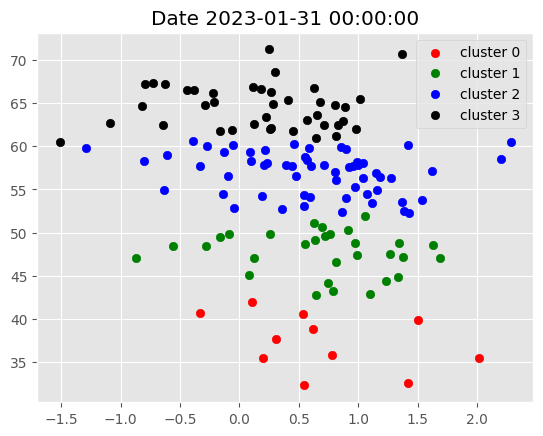

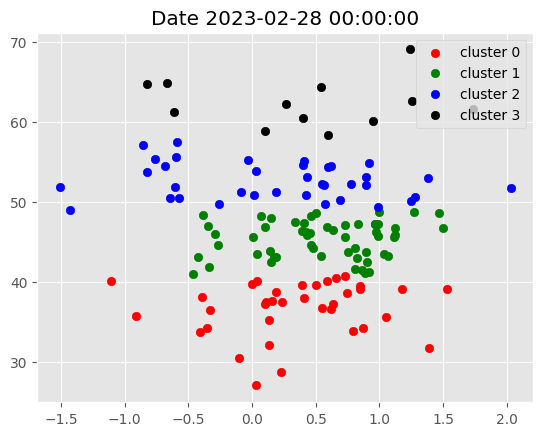

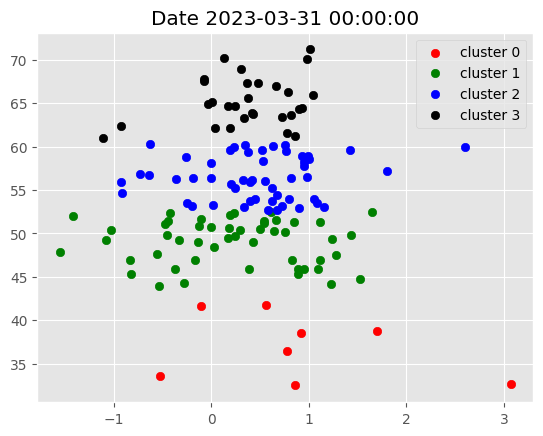

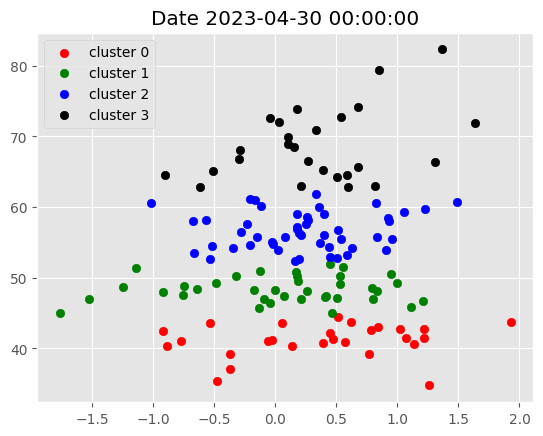

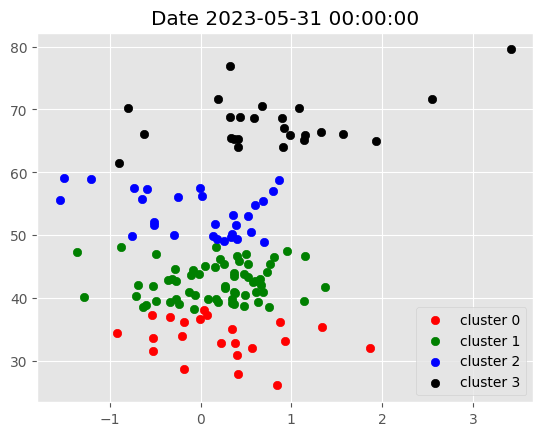

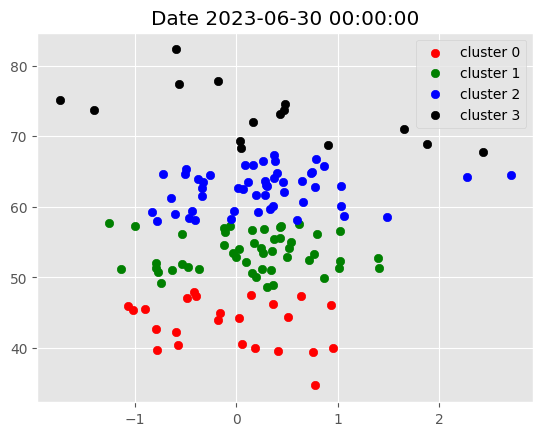

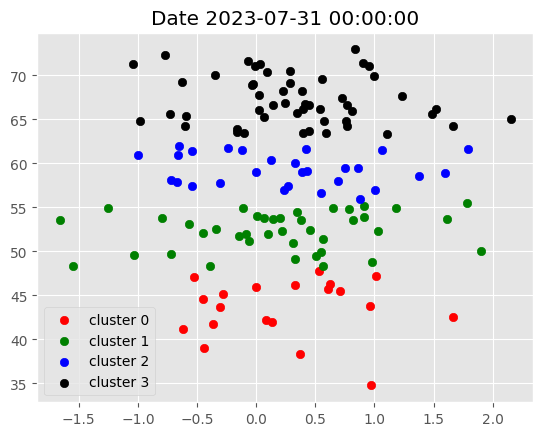

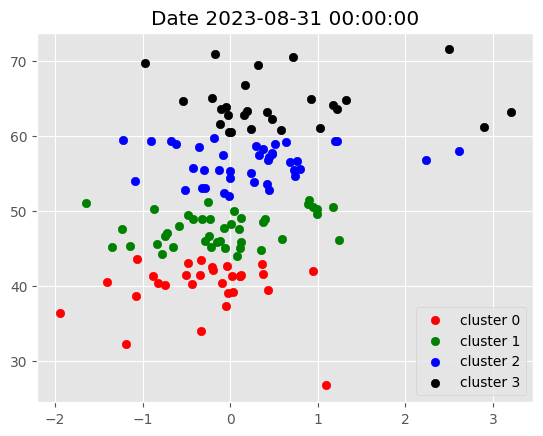

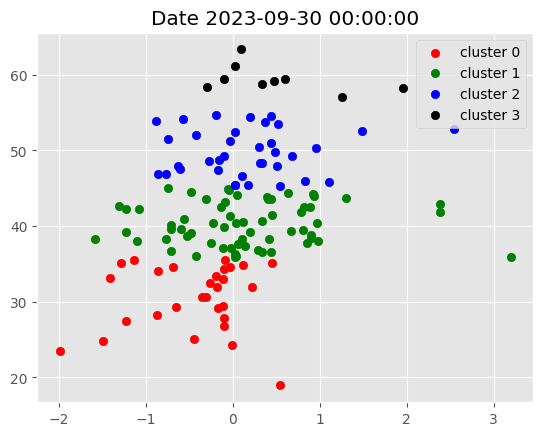

In [142]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

    #the coloring of the cluster cetroids is random
    #Strategy Follow Stocks Momentum: Stocks around 70 rsi are in upward momentum. Invest in stocks of high 60-75 upward rsi momentum
        

<h3>Apply Pre-Defined Centroids to take out the randomness.</h3>

In [139]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

<h3>7.For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization</h3>
<ul>
    <li>First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.</li>
    <li>Momentum is persistent and my idea would be that stocks clustered around</li>
</ul>